## 8.3 批量标准化

论文可见于：[论文链接](https://arxiv.org/abs/1502.03167)

批量标准化 (Batch Normalization) 是一种在深度学习中很常见的技巧，可以通过对每个输入批次的数据进行标准化来提高神经网络的训练速度和准确性。它通过计算数据的均值和方差，将数据按比例缩放和平移使其落在指定的范围内。这样做可以缓解深层神经网络中的梯度消失和爆炸问题，通常被放置在卷积层或全连接层的输入或输出之间，有助于模型收敛。

批量标准化 (Batch Normalization) 是2015年由两位谷歌工程师合作提出的，作者分别是Sergey Ioffe和Christian Szegedy。截止目前为止，论文引用次数已经超过4万。

### 8.3.1 批量标准化基本思想

批量标准化是为了解决深度神经网络训练过程中的两个主要问题：

* 梯度消失/爆炸：当神经网络深度很大时，梯度在传播到网络的较深层时会变得非常小或者非常大，导致梯度消失或者爆炸。这可能会导致模型无法收敛。

* 内部协变量偏移 (Internal Covariate Shift)：这是指在训练过程中，神经网络的中间层输入分布可能会发生变化。这是因为随着训练的进行，前一层的权重可能会发生变化，导致中间层的输入分布发生变化。这可能会导致模型训练变慢，并且可能会影响模型的准确性。

### 8.3.2 批量标准化计算

批量标准化 (Batch Normalization) 的计算其实很简单，经简化后，输出数据 y 的每个元素都是通过如下公式计算得到的：

$$ y = \gamma \cdot \frac{x - x_{mean}}{\sqrt{x_{variance} + \epsilon } } +\beta  $$

其中，$x$ 是输入数据，$ x_{mean}$ 和 $x_{variance}$ 分别是输入数据的均值和方差，$\gamma$ 和 $\beta$ 是批量标准化层的两个可训练参数，$\epsilon$ 是一个很小的常数，用于避免方差为 0 的情况。

批量标准化一般还有另外两个参数，移动平均值和移动方差，用于计算整个数据集的均值和方差。这个同学们了解即可，这里不做赘述。

### 8.3.3 批量标准化代码实现

下面用批量标准化改造一下LeNet模型。

In [1]:
# 导入必要的库
import torch
import torch.nn as nn

重新定义LeNet网络，并增加四个BatchNorm层。

In [2]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 6, 5),
            nn.BatchNorm2d(6)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(6, 16, 5),
            nn.BatchNorm2d(16)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(16 * 4 * 4, 120),
            nn.BatchNorm1d(120)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(120, 84),
            nn.BatchNorm1d(84)
        )
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2)
        x = x.view(-1, 16 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

替换LeNet结构重新进行训练，相比原始LeNet又有提升。

100%|██████████| 10/10 [02:32<00:00, 15.26s/it]


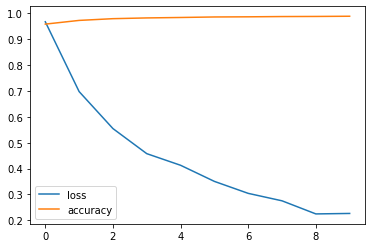

Accuracy: 0.9885


In [4]:
# 导入必要的库
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import *
import numpy as np

# 设置随机种子
torch.manual_seed(0)

# 定义模型、优化器、损失函数
model = LeNet()
optimizer = optim.SGD(model.parameters(), lr=0.02)
criterion = nn.CrossEntropyLoss()

# 设置数据变换和数据加载器
transform = transforms.Compose([
    transforms.ToTensor(),  # 将数据转换为张量
    transforms.Normalize((0.5,), (0.5,))  # 对数据进行归一化
])
train_dataset = datasets.MNIST(root='../data', train=True, download=True, transform=transform)  # 加载训练数据
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)  # 实例化训练数据加载器
test_dataset = datasets.MNIST(root='../data', train=False, download=True, transform=transform)  # 加载测试数据
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)  # 实例化测试数据加载器

# 设置epoch数并开始训练
num_epochs = 10  # 设置epoch数
loss_history = []  # 创建损失历史记录列表
acc_history = []   # 创建准确率历史记录列表

for epoch in tqdm(range(num_epochs)):
    # 批量训练
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    # 测试模型
    model.eval()
    with torch.no_grad():
        total_test_loss = 0
        total_test_correct = 0
        for inputs, labels in test_loader:
            outputs = model(inputs)
            total_test_loss += criterion(outputs, labels).item()
            total_test_correct += (outputs.argmax(1) == labels).sum().item()
        
    # 输出测试集上的损失和准确率
    loss_history.append(np.log10(total_test_loss))  # 将损失加入损失历史记录列表，由于数值较大，这里取对数
    acc_history.append(total_test_correct / len(test_dataset))# 将准确率加入准确率历史记录列表

# 使用图表库（例如Matplotlib）绘制损失和准确率的曲线图
import matplotlib.pyplot as plt
plt.plot(loss_history, label='loss')
plt.plot(acc_history, label='accuracy')
plt.legend()
plt.show()

# 输出准确率
print("Accuracy:", acc_history[-1])

### 8.3.4 小结

* 通过对输入和中间网络层的输出进行标准化处理后，减少了内部神经元分布的改变，使降低了不同样本间值域的差异性，得大部分的数据都其处在非饱和区域，从而保证了梯度能够很好的回传，避免了梯度消失和梯度爆炸。
* 通过减少梯度对参数或其初始值尺度的依赖性，使得我们可以使用较大的学习速率对网络进行训练，从而加速网络的收敛。
* 由于在训练的过程中批量标准化所用到的均值和方差是在一小批样本(mini-batch)上计算的，而不是在整个数据集上，所以均值和方差会有一些小噪声产生，同时缩放过程由于用到了含噪声的标准化后的值，所以也会有一点噪声产生，这迫使后面的神经元单元不过分依赖前面的神经元单元。所以，它也可以看作是一种正则化手段，提高了网络的泛化能力，使得我们可以减少或者取消 Dropout，从而优化网络结构。